In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import copy

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [5]:
len(ef)

61532

In [6]:
F = (ef['use_record'] == 1)

In [7]:
ef = ef.loc[F]
len(ef)

9320

In [12]:
ef['has_echo'] = ~np.isnan(ef.ea_key)

In [13]:
ef.ea_lv_systolic.fillna(value=-99, inplace=True)

In [14]:
ef.groupby(['has_echo', 'ea_lv_systolic']).apply(len)

has_echo  ea_lv_systolic
False     -99.0             5634
True      -99.0              430
          -3.0                30
          -2.0                71
          -1.0               308
           0.0              2297
           1.0               183
           2.0               147
           3.0               220
dtype: int64

In [25]:
L = {}
L[(False, -99.0)] = 'No echo'
L[(True, -99.0)] = 'LV missing'
L[(True, -3.0)] = 'LV cannot assess'
L[(True, -2.0)] = 'LV depressed (unkown)'
L[(True, -1.0)] = 'LV hyperdynamic'
L[(True, 0.0)] = 'LV normal'
L[(True, 1.0)] = 'LV depressed (mild)'
L[(True, 2.0)] = 'LV depressed (moderate)'
L[(True, 3.0)] = 'LV depressed (severe)'

In [27]:
ef['lv_group'] = ef.apply(lambda x: L[(x.has_echo, x.ea_lv_systolic)], axis=1)

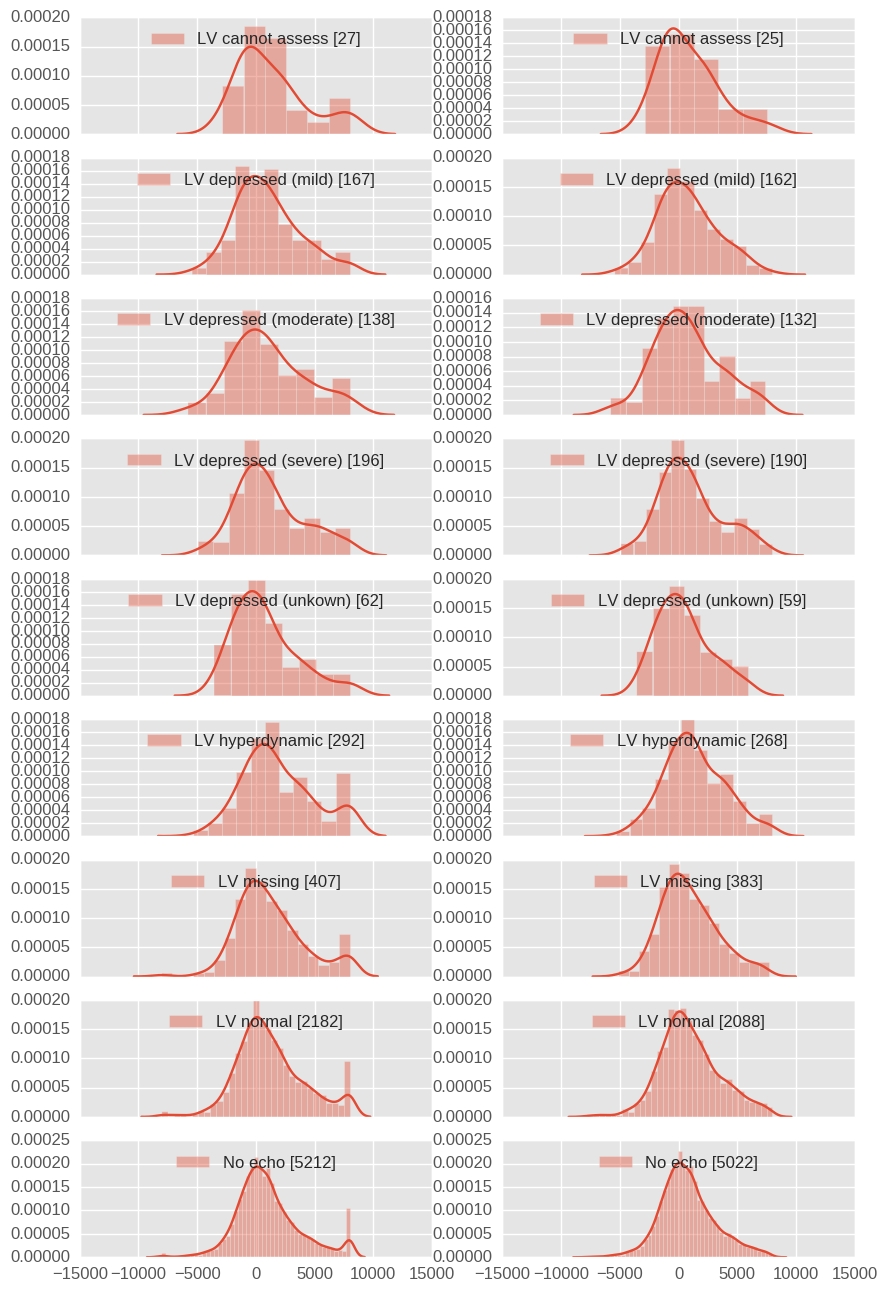

In [38]:
N = len(ef.lv_group.unique())
_, ax = plt.subplots(N, 2, figsize=(10, 16), sharex=True)
i = 0
for label,group in ef.groupby('lv_group'):
    x_ = group.fb_day1_balance_ml.values
    x_ = x_[~np.isnan(x_)]
    sns.distplot(x_, ax=ax[i,0], label=label + ' [{}]'.format(len(x_)))
    ax[i,0].legend(loc='upper center')
    
    F = (group.fb_day1_balance_ml < 8000) & (group.fb_day1_balance_ml > -8000)
    x_ = group.fb_day1_balance_ml.loc[F].values
    x_ = x_[~np.isnan(x_)]
    sns.distplot(x_, ax=ax[i,1], label=label + ' [{}]'.format(len(x_)))
    ax[i,1].legend(loc='upper center')
    i += 1


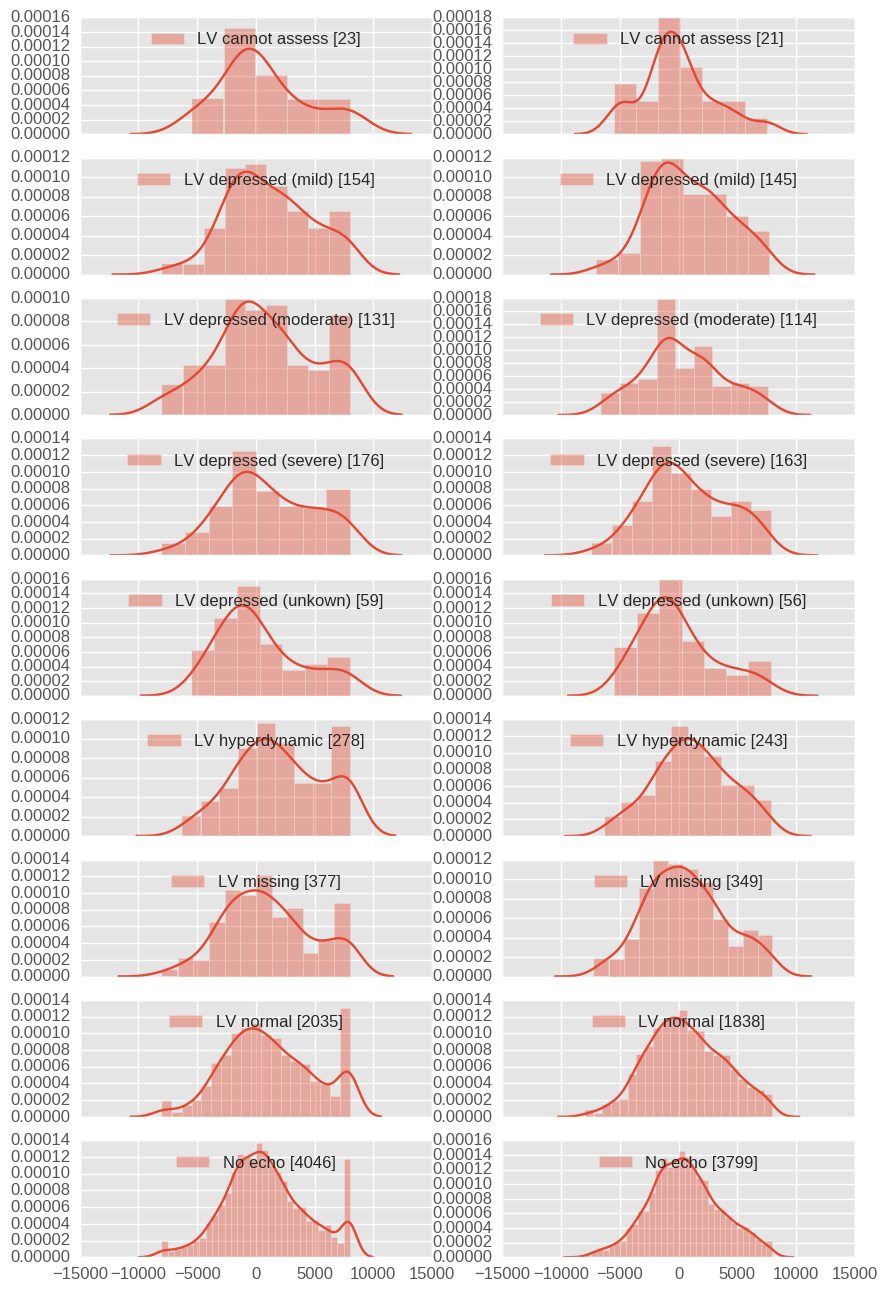

In [39]:
N = len(ef.lv_group.unique())
_, ax = plt.subplots(N, 2, figsize=(10, 16), sharex=True)
i = 0
for label,group in ef.groupby('lv_group'):
    x_ = group.fb_day2_balance_ml.values
    x_ = x_[~np.isnan(x_)]
    sns.distplot(x_, ax=ax[i,0], label=label + ' [{}]'.format(len(x_)))
    ax[i,0].legend(loc='upper center')
    
    F = (group.fb_day2_balance_ml < 8000) & (group.fb_day2_balance_ml > -8000)
    x_ = group.fb_day2_balance_ml.loc[F].values
    x_ = x_[~np.isnan(x_)]
    sns.distplot(x_, ax=ax[i,1], label=label + ' [{}]'.format(len(x_)))
    ax[i,1].legend(loc='upper center')
    i += 1


In [8]:
ef.ea_lv_systolic.value_counts()

 0.0    2297
-1.0     308
 3.0     220
 1.0     183
 2.0     147
-2.0      71
-3.0      30
Name: ea_lv_systolic, dtype: int64

In [12]:
ef.groupby('has_echo').apply(lambda x: x.gender.value_counts())

gender,M,F
has_echo,,
False,2935,2699
True,1920,1766


In [13]:
ef.groupby('has_echo').apply(lambda x: x.gender.value_counts(normalize=True))

gender,M,F
has_echo,,
False,0.520944,0.479056
True,0.520890,0.479110


In [41]:
ef.groupby('lv_group').apply(lambda x: x.gender.value_counts()).unstack(-1)

,F,M
lv_group,,
LV cannot assess,9,21
LV depressed (mild),76,107
LV depressed (moderate),67,80
LV depressed (severe),88,132
LV depressed (unkown),30,41
LV hyperdynamic,169,139
LV missing,175,255
LV normal,1152,1145
No echo,2699,2935


In [15]:
ef.groupby(['has_echo', 'ea_lv_systolic']).apply(lambda x: x.gender.value_counts(normalize=True)).unstack(2)

F         M
has_echo ea_lv_systolic                    
False    -99.0           0.479056  0.520944
True     -99.0           0.406977  0.593023
         -3.0            0.300000  0.700000
         -2.0            0.422535  0.577465
         -1.0            0.548701  0.451299
          0.0            0.501524  0.498476
          1.0            0.415301  0.584699
          2.0            0.455782  0.544218
          3.0            0.400000  0.600000

In [123]:
def subgroup(groups):
    counts = {}
    proportions = {}
    if type(groups) is not list:
        groups = [groups]
    #counts = ef.groupby(groups).apply(lambda x: x.has_echo.value_counts())
    #if type(counts) is pd.Series:
    #    counts = counts.unstack(-1).fillna(0)
    for g in groups:
        table = ef.groupby('has_echo').apply(lambda x: x[g].value_counts())
        if type(table) is pd.Series:
            table = table.unstack(-1).fillna(0)
        counts[g] = table
        proportions[g] = table.div(table.sum(axis=1), axis=0)
    counts = pd.concat(counts, axis=1)
    proportions = pd.concat(proportions, axis=1)
    display(counts)
    display(proportions)
    
    counts = {}
    proportions = {}
    for g in groups:
        table = ef.groupby('lv_group').apply(lambda x: x[g].value_counts())
        if type(table) is pd.Series:
            table = table.unstack(-1).fillna(0)
        #table = table.reset_index()
        counts[g] = table
        proportions[g] = table.div(table.sum(axis=1), axis=0)
    counts = pd.concat(counts, axis=1)
    proportions = pd.concat(proportions, axis=1)
    display(counts)
    
    _, ax = plt.subplots(figsize=(8,12))
    ax = sns.heatmap(proportions.T, annot=True, cmap='RdBu_r', vmin=0, vmax=1, ax=ax)
    ax.hlines([range(2, proportions.shape[1], 2)], *ax.get_xlim(), linewidth=4
             )
    
    display(proportions)
    
    #display(ef.groupby('has_echo').apply(lambda x: x[g].value_counts()))
    #display(ef.groupby('has_echo').apply(lambda x: x[g].value_counts(normalize=True)))
    #display(ef.groupby(['has_echo', 'ea_lv_systolic']).apply(lambda x: x[g].value_counts()).unstack(2))
    #display(ef.groupby(['has_echo', 'ea_lv_systolic']).apply(lambda x: x[g].value_counts(normalize=True)).unstack(2))
    
    
    

In [124]:
ef.vf_first_day_vent.unique()

array([1, 0])

In [125]:
ef['apache_high'] = (ef.apsiii > 60)

In [129]:
for col in ef.columns:
    if 'ex' in col:
        print(col)

ex_congestive_heart_failure
ex_cardiac_aarrhythmias
ex_valvular_disease
ex_pulmonary_circulation
ex_peripheral_vascular
ex_hypertension
ex_paralysis
ex_other_neurological
ex_chronic_pulmonary
ex_diabetes_uncomplicated
ex_diabetes_complicated
ex_hypothyroidism
ex_renal_failure
ex_liver_disease
ex_peptic_ulcer
ex_aids
ex_lymphoma
ex_metastatic_cancer
ex_solid_tumor
ex_rheumatoid_arthritis
ex_coagulopathy
ex_obesity
ex_weight_loss
ex_fluid_electrolyte
ex_blood_loss_anemia
ex_deficiency_anemias
ex_alcohol_abuse
ex_drug_abuse
ex_psychoses
ex_depression
pc_toexclude


apache_high       ex_cardiac_aarrhythmias        \
               False  True                   False  True   
has_echo                                                   
False           4097  1537                    4173  1461   
True            2408  1278                    2511  1175   

         ex_congestive_heart_failure       ex_obesity      ex_renal_failure  \
                               False  True      False True            False   
has_echo                                                                      
False                           4369  1265       5346  288             4930   
True                            2369  1317       3428  258             3140   

              ex_valvular_disease      filter_vaso      gender       st_micu  \
         True               False True       False True      M     F    True   
has_echo                                                                       
False     704                5238  396        5040  594   2935  2699    4130   
True      546                3306  380        2919  767   1920  1766    2965   

               vf_first_day_vent        
         False             False  True  
has_echo                                
False     1504              3046  2588  
True       721              1548  2138

apache_high           ex_cardiac_aarrhythmias            \
               False      True                   False      True   
has_echo                                                           
False       0.727192  0.272808                0.740682  0.259318   
True        0.653283  0.346717                0.681226  0.318774   

         ex_congestive_heart_failure           ex_obesity            \
                               False      True      False      True   
has_echo                                                              
False                       0.775470  0.224530   0.948882  0.051118   
True                        0.642702  0.357298   0.930005  0.069995   

         ex_renal_failure           ex_valvular_disease           filter_vaso  \
                    False      True               False      True       False   
has_echo                                                                        
False            0.875044  0.124956            0.929712  0.070288    0.894569   
True             0.851872  0.148128            0.896907  0.103093    0.791915   

                      gender             st_micu           vf_first_day_vent  \
              True         M         F      True     False             False   
has_echo                                                                       
False     0.105431  0.520944  0.479056  0.733049  0.266951          0.540646   
True      0.208085  0.520890  0.479110  0.804395  0.195605          0.419967   

                    
              True  
has_echo            
False     0.459354  
True      0.580033

apache_high       ex_cardiac_aarrhythmias        \
                              False  True                   False  True   
lv_group                                                                  
LV cannot assess                 17    13                      18    12   
LV depressed (mild)             117    66                     111    72   
LV depressed (moderate)          86    61                      99    48   
LV depressed (severe)           138    82                     146    74   
LV depressed (unkown)            43    28                      48    23   
LV hyperdynamic                 172   136                     226    82   
LV missing                      293   137                     258   172   
LV normal                      1542   755                    1605   692   
No echo                        4097  1537                    4173  1461   

                        ex_congestive_heart_failure       ex_obesity       \
                                              False  True      False True   
lv_group                                                                    
LV cannot assess                                 17    13         27    3   
LV depressed (mild)                              90    93        174    9   
LV depressed (moderate)                          58    89        140    7   
LV depressed (severe)                            75   145        212    8   
LV depressed (unkown)                            31    40         68    3   
LV hyperdynamic                                 229    79        290   18   
LV missing                                      230   200        402   28   
LV normal                                      1639   658       2115  182   
No echo                                        4369  1265       5346  288   

                        ex_renal_failure      ex_valvular_disease       \
                                   False True               False True   
lv_group                                                                 
LV cannot assess                      24    6                  28    2   
LV depressed (mild)                  149   34                 153   30   
LV depressed (moderate)              126   21                 120   27   
LV depressed (severe)                177   43                 180   40   
LV depressed (unkown)                 60   11                  64    7   
LV hyperdynamic                      268   40                 287   21   
LV missing                           342   88                 377   53   
LV normal                           1994  303                2097  200   
No echo                             4930  704                5238  396   

                        filter_vaso      gender       st_micu        \
                              False True      F     M    True False   
lv_group                                                              
LV cannot assess                 22    8      9    21      28     2   
LV depressed (mild)             146   37     76   107     148    35   
LV depressed (moderate)         115   32     67    80     118    29   
LV depressed (severe)           159   61     88   132     193    27   
LV depressed (unkown)            53   18     30    41      68     3   
LV hyperdynamic                 221   87    169   139     222    86   
LV missing                      339   91    175   255     361    69   
LV normal                      1864  433   1152  1145    1827   470   
No echo                        5040  594   2699  2935    4130  1504   

                        vf_first_day_vent        
                                    False  True  
lv_group                                         
LV cannot assess                        6    24  
LV depressed (mild)                    86    97  
LV depressed (moderate)                47   100  
LV depressed (severe)                  99   121  
LV depressed (unkown)                  26    45  
LV hyperdynamic                       106   202  
LV mis

apache_high           ex_cardiac_aarrhythmias  \
                              False      True                   False   
lv_group                                                                
LV cannot assess           0.566667  0.433333                0.600000   
LV depressed (mild)        0.639344  0.360656                0.606557   
LV depressed (moderate)    0.585034  0.414966                0.673469   
LV depressed (severe)      0.627273  0.372727                0.663636   
LV depressed (unkown)      0.605634  0.394366                0.676056   
LV hyperdynamic            0.558442  0.441558                0.733766   
LV missing                 0.681395  0.318605                0.600000   
LV normal                  0.671310  0.328690                0.698737   
No echo                    0.727192  0.272808                0.740682   

                                  ex_congestive_heart_failure            \
                             True                       False      True   
lv_group                                                                  
LV cannot assess         0.400000                    0.566667  0.433333   
LV depressed (mild)      0.393443                    0.491803  0.508197   
LV depressed (moderate)  0.326531                    0.394558  0.605442   
LV depressed (severe)    0.336364                    0.340909  0.659091   
LV depressed (unkown)    0.323944                    0.436620  0.563380   
LV hyperdynamic          0.266234                    0.743506  0.256494   
LV missing               0.400000                    0.534884  0.465116   
LV normal                0.301263                    0.713539  0.286461   
No echo                  0.259318                    0.775470  0.224530   

                        ex_obesity           ex_renal_failure            \
                             False      True            False      True   
lv_group                                                                  
LV cannot assess          0.900000  0.100000         0.800000  0.200000   
LV depressed (mild)       0.950820  0.049180         0.814208  0.185792   
LV depressed (moderate)   0.952381  0.047619         0.857143  0.142857   
LV depressed (severe)     0.963636  0.036364         0.804545  0.195455   
LV depressed (unkown)     0.957746  0.042254         0.845070  0.154930   
LV hyperdynamic           0.941558  0.058442         0.870130  0.129870   
LV missing                0.934884  0.065116         0.795349  0.204651   
LV normal                 0.920766  0.079234         0.868089  0.131911   
No echo                   0.948882  0.051118         0.875044  0.124956   

                        ex_valvular_disease           filter_vaso            \
                                      False      True       False      True   
lv_group                                                                      
LV cannot assess                   0.933333  0.066667    0.733333  0.266667   
LV depressed (mild)                0.836066  0.163934    0.797814  0.202186   
LV depressed (moderate)            0.816327  0.183673    0.782313  0.217687   
LV depressed (severe)              0.818182  0.181818    0.722727  0.277273   
LV depressed (unkown)              0.901408  0.098592    0.746479  0.253521   
LV hyperdynamic                    0.931818  0.068182    0.717532  0.282468   
LV missing                         0.876744  0.123256    0.788372  0.211628   
LV normal                          0.912930  0.087070    0.811493  0.188507   
No echo                            0.929712  0.070288    0.894569  0.105431   

                           gender             st_micu            \
                                F         M      True     False   
lv_group                                                          
LV cannot assess         0.300000  0.700000  0.933333  0.066667   
LV depressed (mild)      0.415301  0.584699  0.808743  0.191257   
LV depressed (moderate)  0.455782  0.544218  0.802721  0.1972

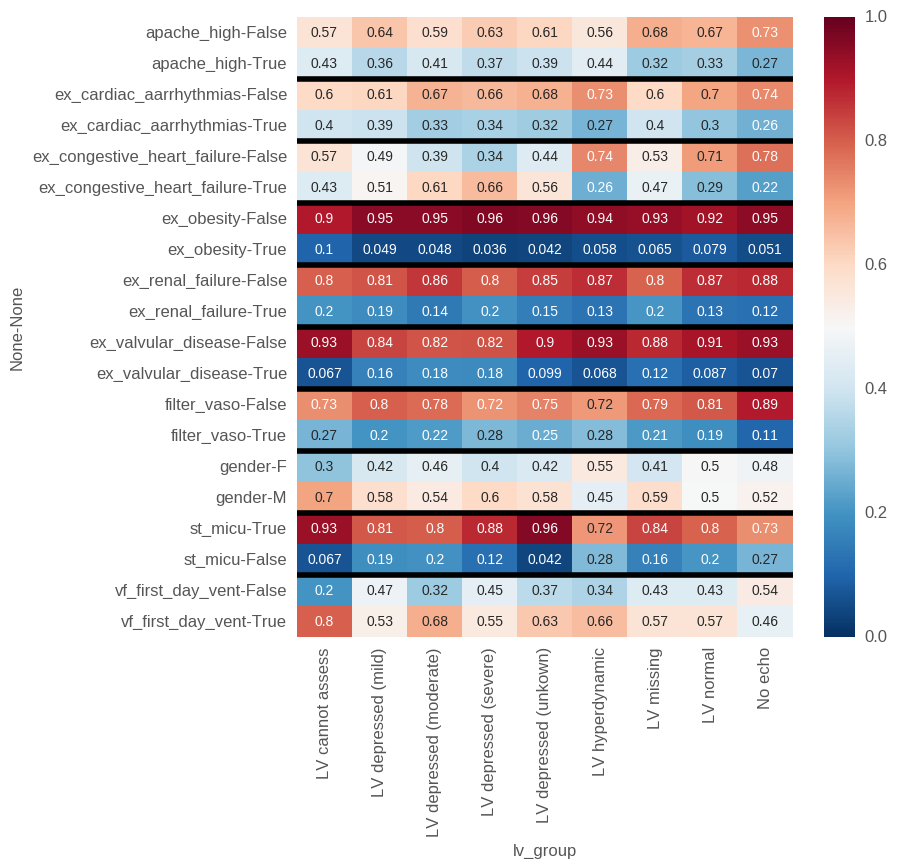

In [134]:
subgroup(['gender', 'ex_congestive_heart_failure', 'vf_first_day_vent', 'filter_vaso', 'apache_high', 'st_micu'
         , 'ex_obesity', 'ex_valvular_disease', 'ex_cardiac_aarrhythmias', 'ex_renal_failure'])

In [83]:
from scipy.stats import ttest_ind

fl = 'fb_day1_balance_ml'

baseline = ef.loc[ef.lv_group == 'LV normal'][fl].values
baseline = baseline[~np.isnan(baseline)]

labels = sorted(ef.lv_group.unique().tolist())
table = []
for i in range(len(labels)):
    x_ = ef.loc[ef.lv_group == labels[i]][fl]
    x_ = x_.values
    x_ = x_[~np.isnan(x_)]
    
    delta = x_.mean() - baseline.mean()
    _, pval = ttest_ind(x_, baseline, equal_var=False)
    signif = (pval < 0.05)
    
    row = {'lv_group': labels[i], 'delta': delta, 'p-value': pval, 'significant @ p=0.05': signif}
    table.append(row)
    
table = pd.DataFrame(table)
table

,delta,lv_group,p-value,significant @ p=0.05
0,151.167603,LV cannot assess,0.800928,False
1,-270.762187,LV depressed (mild),0.229506,False
2,-166.938446,LV depressed (moderate),0.548912,False
3,-11.980857,LV depressed (severe),0.956176,False
4,-426.480718,LV depressed (unkown),0.234788,False
5,688.497497,LV hyperdynamic,0.000353,True
6,5.508432,LV missing,0.971969,False
7,0.000000,LV normal,1.000000,False
8,-237.002729,No echo,0.001125,True


In [84]:
from scipy.stats import ttest_ind

fl = 'fb_day1_balance_ml'

baseline = ef.loc[ef.lv_group == 'LV normal'][fl]
F = (baseline < 8000) & (baseline > -8000)
baseline = baseline.loc[F].values
baseline = baseline[~np.isnan(baseline)]

labels = sorted(ef.lv_group.unique().tolist())
table = []
for i in range(len(labels)):
    x_ = ef.loc[ef.lv_group == labels[i]][fl]
    F = (x_ < 8000) & (x_ > -8000)
    x_ = x_.loc[F].values
    x_ = x_[~np.isnan(x_)]
    
    delta = x_.mean() - baseline.mean()
    _, pval = ttest_ind(x_, baseline, equal_var=False)
    signif = (pval < 0.05)
    
    row = {'lv_group': labels[i], 'delta': delta, 'p-value': pval, 'significant @ p=0.05': signif}
    table.append(row)
    
table = pd.DataFrame(table)
table

,delta,lv_group,p-value,significant @ p=0.05
0,-119.049560,LV cannot assess,0.815137,False
1,-229.463942,LV depressed (mild),0.269407,False
2,-223.445090,LV depressed (moderate),0.385760,False
3,32.466993,LV depressed (severe),0.873704,False
4,-533.519686,LV depressed (unkown),0.082058,False
5,403.307677,LV hyperdynamic,0.017198,True
6,-75.777051,LV missing,0.574436,False
7,0.000000,LV normal,1.000000,False
8,-201.981936,No echo,0.002050,True


In [85]:
from scipy.stats import ttest_ind

fl = 'fb_day2_balance_ml'

baseline = ef.loc[ef.lv_group == 'LV normal'][fl].values
baseline = baseline[~np.isnan(baseline)]

labels = sorted(ef.lv_group.unique().tolist())
table = []
for i in range(len(labels)):
    x_ = ef.loc[ef.lv_group == labels[i]][fl]
    x_ = x_.values
    x_ = x_[~np.isnan(x_)]
    
    delta = x_.mean() - baseline.mean()
    _, pval = ttest_ind(x_, baseline, equal_var=False)
    signif = (pval < 0.05)
    
    row = {'lv_group': labels[i], 'delta': delta, 'p-value': pval, 'significant @ p=0.05': signif}
    table.append(row)
    
table = pd.DataFrame(table)
table

,delta,lv_group,p-value,significant @ p=0.05
0,-506.456019,LV cannot assess,0.532828,False
1,24.692090,LV depressed (mild),0.935432,False
2,-389.148967,LV depressed (moderate),0.307483,False
3,-20.161166,LV depressed (severe),0.947508,False
4,-816.676307,LV depressed (unkown),0.092581,False
5,883.900346,LV hyperdynamic,0.000298,True
6,-118.807050,LV missing,0.578007,False
7,0.000000,LV normal,1.000000,False
8,-321.653257,No echo,0.001498,True


In [86]:
from scipy.stats import ttest_ind

fl = 'fb_day2_balance_ml'

baseline = ef.loc[ef.lv_group == 'LV normal'][fl]
F = (baseline < 8000) & (baseline > -8000)
baseline = baseline.loc[F].values
baseline = baseline[~np.isnan(baseline)]

labels = sorted(ef.lv_group.unique().tolist())
table = []
for i in range(len(labels)):
    x_ = ef.loc[ef.lv_group == labels[i]][fl]
    F = (x_ < 8000) & (x_ > -8000)
    x_ = x_.loc[F].values
    x_ = x_[~np.isnan(x_)]
    
    delta = x_.mean() - baseline.mean()
    _, pval = ttest_ind(x_, baseline, equal_var=False)
    signif = (pval < 0.05)
    
    row = {'lv_group': labels[i], 'delta': delta, 'p-value': pval, 'significant @ p=0.05': signif}
    table.append(row)
    
table = pd.DataFrame(table)
table

,delta,lv_group,p-value,significant @ p=0.05
0,-655.885053,LV cannot assess,0.357863,False
1,262.023198,LV depressed (mild),0.354495,False
2,-214.821645,LV depressed (moderate),0.513166,False
3,80.995913,LV depressed (severe),0.775830,False
4,-676.908426,LV depressed (unkown),0.127354,False
5,576.594837,LV hyperdynamic,0.009528,True
6,10.559312,LV missing,0.956821,False
7,0.000000,LV normal,1.000000,False
8,-89.850378,No echo,0.321085,False


In [87]:
from scipy.stats import ttest_ind

fl = 'fb_day3_balance_ml'

baseline = ef.loc[ef.lv_group == 'LV normal'][fl].values
baseline = baseline[~np.isnan(baseline)]

labels = sorted(ef.lv_group.unique().tolist())
table = []
for i in range(len(labels)):
    x_ = ef.loc[ef.lv_group == labels[i]][fl]
    x_ = x_.values
    x_ = x_[~np.isnan(x_)]
    
    delta = x_.mean() - baseline.mean()
    _, pval = ttest_ind(x_, baseline, equal_var=False)
    signif = (pval < 0.05)
    
    row = {'lv_group': labels[i], 'delta': delta, 'p-value': pval, 'significant @ p=0.05': signif}
    table.append(row)
    
table = pd.DataFrame(table)
table

,delta,lv_group,p-value,significant @ p=0.05
0,-860.762419,LV cannot assess,0.450617,False
1,-59.313274,LV depressed (mild),0.879312,False
2,-643.897740,LV depressed (moderate),0.178138,False
3,94.813922,LV depressed (severe),0.827069,False
4,-395.222529,LV depressed (unkown),0.519322,False
5,874.050753,LV hyperdynamic,0.003321,True
6,-269.670799,LV missing,0.312603,False
7,0.000000,LV normal,1.000000,False
8,-361.949847,No echo,0.006806,True


In [88]:
from scipy.stats import ttest_ind

fl = 'fb_day3_balance_ml'

baseline = ef.loc[ef.lv_group == 'LV normal'][fl]
F = (baseline < 8000) & (baseline > -8000)
baseline = baseline.loc[F].values
baseline = baseline[~np.isnan(baseline)]

labels = sorted(ef.lv_group.unique().tolist())
table = []
for i in range(len(labels)):
    x_ = ef.loc[ef.lv_group == labels[i]][fl]
    F = (x_ < 8000) & (x_ > -8000)
    x_ = x_.loc[F].values
    x_ = x_[~np.isnan(x_)]
    
    delta = x_.mean() - baseline.mean()
    _, pval = ttest_ind(x_, baseline, equal_var=False)
    signif = (pval < 0.05)
    
    row = {'lv_group': labels[i], 'delta': delta, 'p-value': pval, 'significant @ p=0.05': signif}
    table.append(row)
    
table = pd.DataFrame(table)
table

,delta,lv_group,p-value,significant @ p=0.05
0,-709.199276,LV cannot assess,0.490104,False
1,198.164995,LV depressed (mild),0.588037,False
2,-243.745636,LV depressed (moderate),0.567190,False
3,227.322014,LV depressed (severe),0.573652,False
4,-446.954519,LV depressed (unkown),0.388818,False
5,422.899551,LV hyperdynamic,0.119935,False
6,-249.780537,LV missing,0.288044,False
7,0.000000,LV normal,1.000000,False
8,-98.533787,No echo,0.404771,False


In [73]:
def subgroup(g):
    from scipy.stats import fisher_exact, chi2_contingency
    
   
        
    
    counts = ef.groupby(g).apply(lambda x: x.mortality.value_counts())
    if type(counts) is pd.Series:
        counts = counts.unstack(-1).fillna(value=0)
    marginal = counts.sum(axis=0)
    #if type(g) is list:
    #    counts = counts.unstack(-1)
        
    display(counts)
    
    marginal = float(marginal.loc[True])/marginal.sum()
    proportions = counts.div(counts.sum(axis=1), axis=0)
    proportions['fold_change'] = proportions[True]/marginal
    
    if len(proportions) > 2:
        pval_array = np.zeros(len(proportions))
        for i in range(len(proportions)):
            this = counts.iloc[i]
            rest = counts.sum() - this
            table = pd.DataFrame([this, rest])
            _, pval = fisher_exact(table)
            pval_array[i] = pval
        signif = (pval_array < 0.05)
        proportions['p-value'] = pval_array
        proportions['significant @ p=0.05'] = signif
        proportions['support'] = counts.sum(axis=1)
        
    
    display(proportions)
    #display(counts/counts.sum(axis=1))
    
    if len(counts) == 2:
        _, pval = fisher_exact(counts)
        print('Fisher\'s exact p-value:', pval)
    elif len(counts) > 2:
        if np.any(counts < 5):
            print('Warning! Chi2 not advised if any count < 5')
        _, pval, _, _ = chi2_contingency(counts)
        print('Chi2 p-value:', pval)
    
    ## echo vs no echo
    #counts = ef.groupby('has_echo').apply(lambda x: x[g].value_counts())
    
def subgroup_fluids(g):
    from scipy.stats import ttest_ind
    
    def fluid_analysis(x):
        F = ~(x.fb_day1_balance_truncated == 1)
        fl_live = x.fb_day1_balance_ml.loc[~x.mortality & F]
        fl_live = fl_live.loc[~np.isnan(fl_live)]
        fl_dead = x.fb_day1_balance_ml.loc[x.mortality & F]
        fl_dead = fl_dead.loc[~np.isnan(fl_dead)]
        delta = fl_live.mean() - fl_dead.mean()
        _, pval = ttest_ind(fl_live, fl_dead, equal_var=False)
        signif = (pval < 0.05)
        return pd.Series({'fluid_day1_diff': delta, 'p-value': pval
                          , 'significant @ p=0.05': signif
                          , 'support': len(fl_live)+len(fl_dead)})
    
    if len(g) == 0:
        table = pd.DataFrame([fluid_analysis(ef)])
    else:
        table = ef.groupby(g).apply(fluid_analysis)
    display(table)
    
    

What we want to understand:

+ _p(mortality | $lv_{mild}$, fluids) = p($lv_{mild}$, fluids | mortality)p(mortality)/p($lv_{mild}$, fluids)_
+ Is mortality conditionaly independent of fluids and $lv_{mild}$ given some other variable?
  + find _c_ s.t. _p(mortality, $lv_{mild}$, fluids | c) = p(mortality | c)p($lv_{mild}$, fluids | c)_

In [74]:
tod = ef.dod - ef.intime
ef['mortality'] = tod < np.timedelta64(30, 'D')

In [75]:
subgroup_fluids([])

,fluid_day1_diff,p-value,significant @ p=0.05,support
0,-686.52083,1.103885e-28,True,8329


In [76]:
subgroup('has_echo')

mortality,False,True
has_echo,,
False,4103,1531
True,2597,1089


mortality,False,True,fold_change
has_echo,,,
False,0.728257,0.271743,0.966658
True,0.704558,0.295442,1.050962


Fisher's exact p-value: 0.0133556149149


In [77]:
subgroup_fluids('has_echo')

,fluid_day1_diff,p-value,significant @ p=0.05,support
has_echo,,,,
False,-803.860637,8.311518e-25,True,5022
True,-504.635392,5.009536e-07,True,3307


In [79]:
subgroup('lv_group')

mortality,False,True
lv_group,,
LV cannot assess,19,11
LV depressed (mild),137,46
LV depressed (moderate),98,49
LV depressed (severe),137,83
LV depressed (unkown),38,33
LV hyperdynamic,184,124
LV missing,295,135
LV normal,1689,608
No echo,4103,1531


mortality,False,True,fold_change,p-value,significant @ p=0.05,support
lv_group,,,,,,
LV cannot assess,0.633333,0.366667,1.304326,0.310949,False,30
LV depressed (mild),0.748634,0.251366,0.894173,0.406485,False,183
LV depressed (moderate),0.666667,0.333333,1.185751,0.165373,False,147
LV depressed (severe),0.622727,0.377273,1.342054,0.001804,True,220
LV depressed (unkown),0.535211,0.464789,1.653371,0.001252,True,71
LV hyperdynamic,0.597403,0.402597,1.432140,0.000003,True,308
LV missing,0.686047,0.313953,1.116812,0.124196,False,430
LV normal,0.735307,0.264693,0.941580,0.044952,True,2297
No echo,0.728257,0.271743,0.966658,0.013356,True,5634


Chi2 p-value: 2.70890008027e-09


In [80]:
subgroup_fluids('lv_group')

,fluid_day1_diff,p-value,significant @ p=0.05,support
lv_group,,,,
LV cannot assess,-517.441453,6.336798e-01,False,25
LV depressed (mild),268.645489,5.314346e-01,False,162
LV depressed (moderate),-751.056420,1.987013e-01,False,132
LV depressed (severe),-1191.935608,3.506012e-03,True,190
LV depressed (unkown),-371.720469,5.338452e-01,False,59
LV hyperdynamic,-992.137347,2.947838e-03,True,268
LV missing,-124.767457,6.280460e-01,False,383
LV normal,-472.823157,3.236973e-04,True,2088
No echo,-803.860637,8.311518e-25,True,5022


In [176]:
ef.ea_rv_cavity.fillna(value=-99, inplace=True)

In [177]:
subgroup(['has_echo', 'ea_rv_cavity'])

False   True 
has_echo ea_rv_cavity                
False    -99.0         4103.0  1531.0
True     -99.0          199.0   106.0
         -50.0            0.0     1.0
         -3.0           115.0    48.0
         -2.0           135.0    92.0
         -1.0             5.0     4.0
          0.0          1811.0   679.0
          1.0           221.0    90.0
          2.0           111.0    69.0

False      True  fold_change   p-value  \
has_echo ea_rv_cavity                                              
False    -99.0         0.728257  0.271743     0.966658  0.013356   
True     -99.0         0.652459  0.347541     1.236291  0.009595   
         -50.0         0.000000  1.000000     3.557252  0.281116   
         -3.0          0.705521  0.294479     1.047534  0.725222   
         -2.0          0.594714  0.405286     1.441706  0.000049   
         -1.0          0.555556  0.444444     1.581001  0.279519   
          0.0          0.727309  0.272691     0.970030  0.285731   
          1.0          0.710611  0.289389     1.029430  0.748510   
          2.0          0.616667  0.383333     1.363613  0.003247   

                      significant @ p=0.05  support  
has_echo ea_rv_cavity                                
False    -99.0                        True   5634.0  
True     -99.0                        True    305.0  
         -50.0                       False      1.0  
         -3.0                        False    163.0  
         -2.0                         True    227.0  
         -1.0                        False      9.0  
          0.0                        False   2490.0  
          1.0                        False    311.0  
          2.0                         True    180.0

Warning! Chi2 not advised if any count < 5
Chi2 p-value: 2.47318228119e-06
